In [2]:
import requests
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import TwitterUtils as TU
import seaborn as sns

## Combining Data

The `GetPlaces.py`, `GetTweets.py`, and `SampleUser.py` files have generated the following output files:
* users.json : contains all the user specific data from the 51,000 sampled users
* places.pkl : metadata related to all twitter places in the user sample
* user_data.pkl : retrieved 100 tweets from each user

In [38]:
with open("places.pkl", "rb") as file:
    places = pkl.load(file)

with open('user_data.pkl', 'rb') as file:
    data = pkl.load(file)

with open('users.json', 'r') as file:
    user_json = file.read()

test = '{"total": [' + user_json.replace("}{", "},{") + "]}"
user_data = json.loads(test)
users = [u['data'] for u in user_data["total"]]
flat_list = [user_id for user in users for user_id in user]

users_df = pd.DataFrame(flat_list)

In [5]:
places_unpacked = [item  for item in places.values()]
def unpack_place(place):
    return (place.id, place.name, place.full_name, place.country, place.country_code, place.place_type)

unpacked_places = [unpack_place(place) for place in places_unpacked]
place_df = pd.DataFrame(unpacked_places, columns = ("id", "name", "full_name", "country", "country_code", "type"))


In [12]:
df = pd.DataFrame(data)
merged = pd.merge(df, place_df, how = 'left', left_on = 'place_id', right_on='id')


full_data = pd.merge(merged, users_df, how='left', left_on ='user_id', right_on = 'id')
full_data.to_csv('fulldata.csv', index = False) # 3 Gigs of data, not great...
full_data.description.iloc[0,]
# places_unpacked # Cool opportunity for geographic visualization

array([[<AxesSubplot:>, <AxesSubplot:title={'center':'Afghanistan'}>,
        <AxesSubplot:title={'center':'Albania'}>,
        <AxesSubplot:title={'center':'Algeria'}>,
        <AxesSubplot:title={'center':'American Samoa'}>,
        <AxesSubplot:title={'center':'Angola'}>,
        <AxesSubplot:title={'center':'Antigua and Barbuda'}>,
        <AxesSubplot:title={'center':'Argentina'}>,
        <AxesSubplot:title={'center':'Aruba'}>,
        <AxesSubplot:title={'center':'Australia'}>,
        <AxesSubplot:title={'center':'Austria'}>,
        <AxesSubplot:title={'center':'Bahamas'}>,
        <AxesSubplot:title={'center':'Bahrain'}>],
       [<AxesSubplot:title={'center':'Bangladesh'}>,
        <AxesSubplot:title={'center':'Barbados'}>,
        <AxesSubplot:title={'center':'Belgium'}>,
        <AxesSubplot:title={'center':'Belize'}>,
        <AxesSubplot:title={'center':'Bermuda'}>,
        <AxesSubplot:title={'center':'Bhutan'}>,
        <AxesSubplot:title={'center':'Bolivia'}>,
       

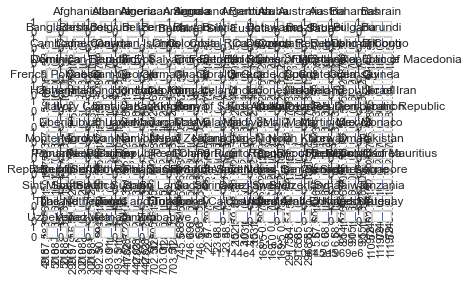

In [37]:
by_country = merged.groupby('country').count()
# by_country.sort_values(by = 'user_id')